# Running ASFMAUS

In [34]:
using StochasticDiffEq
using DiffEqCallbacks
using DifferentialEquations
using Plots
using LinearAlgebra
using DelimitedFiles
using DataFrames
using LinearAlgebra
using SparseArrays
using Distributions

In [107]:
include("/home/callum/ASF/Modules/ASF_input.jl");
include("/home/callum/ASF/Modules/ASF_model.jl");
include("/home/callum/ASF/Modules/ASF_analysis.jl");

In [108]:
input_path = "/home/callum/ASF/Inputs/";

In [116]:
input_1 = ASF_Inputs.Model_Data(input_path); #creating parameters to run model

Watts Strogatz Small Worlds Network


In [117]:
nt = input_1.Parameters.Populations.cum_sum[end] #total number of groups and farms
nc = 5 #number of classes
eqs = 11 #number of processes
n_ens = 100 #number of runs in ensemble

dc = sparse(zeros(nt*nc,nt*eqs))

#const _dc = zeros(nt*5,nt*10)

dc[0*nc*nt+1:nc*nt*eqs+nc:end] .= 1
dc[1*nc*nt+1:nc*nt*eqs+nc:end] .= -1
dc[2*nc*nt+1:nc*nt*eqs+nc:end] .= -1
dc[10*nc*nt+1:nc*nt*eqs+nc:end] .= 1

dc[2*nc*nt+2:nc*nt*eqs+nc:end] .= 1
dc[3*nc*nt+2:nc*nt*eqs+nc:end] .= -1
dc[4*nc*nt+2:nc*nt*eqs+nc:end] .= -1

dc[4*nc*nt+3:nc*nt*eqs+nc:end] .= 1
dc[5*nc*nt+3:nc*nt*eqs+nc:end] .= -1
dc[6*nc*nt+3:nc*nt*eqs+nc:end] .= -1
dc[7*nc*nt+3:nc*nt*eqs+nc:end] .= -1

dc[7*nc*nt+4:nc*nt*eqs+nc:end] .= 1
dc[8*nc*nt+4:nc*nt*eqs+nc:end] .= -1
dc[10*nc*nt+4:nc*nt*eqs+nc:end] .= -1


dc[5*nc*nt+5:nc*nt*eqs+nc:end] .= 1
dc[6*nc*nt+5:nc*nt*eqs+nc:end] .= 1
dc[9*nc*nt+5:nc*nt*eqs+nc:end] .= -1;

In [111]:
function regular_c(du,u,p,t,counts,mark)  
    mul!(du,dc,counts)
    nothing
end

function prob_func(prob,i,repeat) #function to change parameters while keeping network the same
    ASF_Model.reparam!(input_1)
    remake(prob,p=input_1.Parameters)
end 

prob_func (generic function with 1 method)

## Running the Model

### Frequency run

In [112]:
input_1 = ASF_Inputs.Model_Data(input_path); #creating parameters to run model

Watts Strogatz Small Worlds Network


In [141]:
function density_rate_single(out,u,p,t)
    ref_density = 3
    u[u.<0].=0 
    S = u[1:5:end]
    E = u[2:5:end]
    I = u[3:5:end]
    R = u[4:5:end]
    C = u[5:5:end]
    
    Pops = p.Populations
    tp = Pops.cum_sum[end]
    N = S + E + I + R + C .+ 0.0001
    Np = S + E + I + R
    
    beta = copy(p.β)
    N_feral = sum(Np)
    Density = N_feral/Pops.area[1]
    beta[p.β_d .== 1] .*= Density/ref_density
    

    column(i) = N .+ N[i]
    populations  = hcat([column(i) for i=1:tp]...)
    populations[diagind(populations)] = N;
    
  
    connected_pops = p.β_b * Np
 
    Births = p.μ_b .* Np
    Births[(p.μ_c .== 1) .& (Np .> 0)] .= 0 #preventing boar populations growing larger than one!
    Births[(Np .== 0) .& (connected_pops .>2)] .= mean(p.μ_b)*2 #allowing migration births if neighbouring groups have pop
    Infect = ((beta .* S) ./ populations) * (I + p.ω .* C)#ASF Infections
    Infectous = p.ζ .* E
    Recover = p.γ .* (1 .- p.ρ) .* I #ASF Recoveries
    Death_I = p.ρ .* p.γ .* I #ASF Deaths in I
    Death_nI = p.μ_d .* I+ (p.μ_b-p.μ_d)./tanh(1).*I.*tanh.(Np./p.μ_c) #Natural Deaths in I
    Death_S = p.μ_d .* S + (p.μ_b-p.μ_d)./tanh(1).*S.*tanh.(Np./p.μ_c) #Natural Deaths S
    Death_E = p.μ_d .* E + (p.μ_b-p.μ_d)./tanh(1).*E.*tanh.(Np./p.μ_c)
    Death_R = p.μ_d .* R + (p.μ_b-p.μ_d)./tanh(1).*R.*tanh.(Np./p.μ_c) #Natural Deaths R
    Decay_C = p.λ .* C #Body Decomposition 
    W_Immunity = p.κ .* R .* 0
   
    out[1:11:end] = Births
    out[2:11:end] = Death_S
    out[3:11:end] = Infect
    out[4:11:end] = Death_E
    out[5:11:end] = Infectous
    out[6:11:end] = Death_I
    out[7:11:end] = Death_nI
    out[8:11:end] = Recover
    out[9:11:end] = Death_R
    out[10:11:end] = Decay_C
    out[11:11:end] = W_Immunity
    
    nothing
end

density_rate_single (generic function with 1 method)

In [125]:
function density_rate_single2(out,u,p,t)
    ref_density = 3
    u[u.<0].=0 
    S = u[1:5:end]
    E = u[2:5:end]
    I = u[3:5:end]
    R = u[4:5:end]
    C = u[5:5:end]
    
   
 
    Births = p.μ_b .* Np
    Infect = ((p.β .* S) ./ 10) * (I + p.ω .* C)#ASF Infections
    Infectous = p.ζ .* E
    Recover = p.γ .* (1 .- p.ρ) .* I #ASF Recoveries
    Death_I = p.ρ .* p.γ .* I #ASF Deaths in I
    Death_nI = p.μ_d .* I+ (p.μ_b-p.μ_d)./tanh(1).*I.*tanh.(Np./p.μ_c) #Natural Deaths in I
    Death_S = p.μ_d .* S + (p.μ_b-p.μ_d)./tanh(1).*S.*tanh.(Np./p.μ_c) #Natural Deaths S
    Death_E = p.μ_d .* E + (p.μ_b-p.μ_d)./tanh(1).*E.*tanh.(Np./p.μ_c)
    Death_R = p.μ_d .* R + (p.μ_b-p.μ_d)./tanh(1).*R.*tanh.(Np./p.μ_c) #Natural Deaths R
    Decay_C = p.λ .* C #Body Decomposition 
    W_Immunity = p.κ .* R .* 0
   
    out[1:11:end] = Births
    out[2:11:end] = Death_S
    out[3:11:end] = Infect
    out[4:11:end] = Death_E
    out[5:11:end] = Infectous
    out[6:11:end] = Death_I
    out[7:11:end] = Death_nI
    out[8:11:end] = Recover
    out[9:11:end] = Death_R
    out[10:11:end] = Decay_C
    out[11:11:end] = W_Immunity
    
    nothing
end

5-element Vector{Int64}:
 1
 2
 3
 4
 5

In [126]:
column(i) = N .+ N[i]

column (generic function with 1 method)

In [130]:
populations  = hcat([column(i) for i=1:5]...)
populations[diagind(populations)] = N;

In [131]:
populations

5×5 Matrix{Int64}:
 1  3  4  5  6
 3  2  5  6  7
 4  5  3  7  8
 5  6  7  4  9
 6  7  8  9  5

In [144]:
N_years = 5
n_ens = 10

rj = RegularJump(density_rate_single, regular_c, eqs*nt)

prob = DiscreteProblem(input_1.U0,(0.0,365.0*N_years),input_1.Parameters)

jump_prob = JumpProblem(prob,Direct(),rj)

sol = solve(jump_prob, SimpleTauLeaping(), dt= 1)#callback=DiscreteCallback(pcondit,paffect!), dt=1 ) ;
#ensemble_prob_m = EnsembleProblem(jump_prob)#,prob_func=prob_func)
#output = solve(ensemble_prob_m, SimpleTauLeaping(), dt=1, trajectories= n_ens);

In [83]:
data = reduce(vcat,transpose.(sol.u))
    
if any(x->x <0, data)
    println("Need to Reduce Timestep")
    data[data .< 0 ] .= 0
end

s_d = data[:,1:5:end]
e_d = data[:,2:5:end]
i_d = data[:,3:5:end]
r_d = data[:,4:5:end]
c_d = data[:,5:5:end]

disease = e_d + i_d + c_d #classes with disease
disease_free = s_d + r_d #classes without disease
live_disease = e_d + i_d
total_pop = e_d + i_d + s_d + r_d

disease_sum = sum(disease,dims=2);
disease_free_sum = sum(disease_free,dims=2);
population_sum = sum(total_pop,dims=2);
live_disease_sum = sum(live_disease,dims=2);

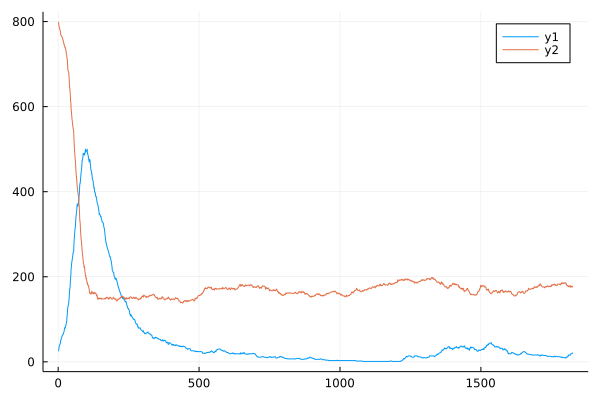

In [82]:
plot(disease_sum)
plot!(disease_free_sum)

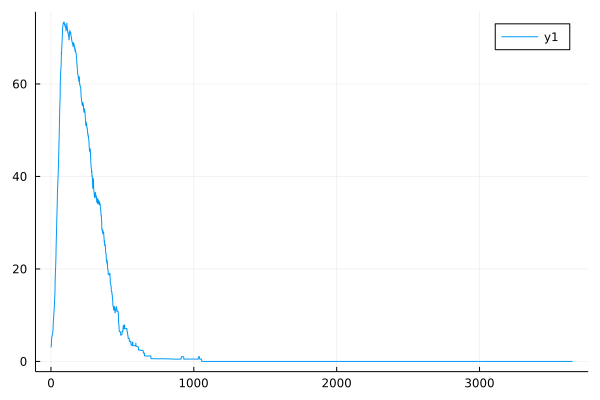

In [13]:

plot(100*(disease_sum./(disease_free_sum + disease_sum)))

In [109]:
function SEIRC_ODE!(du,u,p,t)
    
    ref_density = 3
    
    u[u.<0].=0 
    
    S = u[1:5:end]
    E = u[2:5:end]
    I = u[3:5:end]
    R = u[4:5:end]
    C = u[5:5:end]
  
    N = S + E + I + R + C .+ 0.0001
    Np = S + E + I + R
    
    Pops = p.Populations 
    
    tp = Pops.cum_sum[end]

    beta = copy(p.β)
    
   
    #calculating density of region
    #for i in 1:Pops.pop
    #    nf = Pops.feral[i] #number of feral groups in region
    #    ncs = Pops.cum_sum[i] #cumsum of farm and ferals over all regions
    N_feral = sum(Np) #total feral population in region i
    Density = N_feral/Pops.area[1]
    beta = beta * Density/ref_density
   #end

    column(i) = N .+ N[i]
    populations  = hcat([column(i) for i=1:tp]...)
    populations[diagind(populations)] = N;

    connected_pops = p.β_b * Np

    #procceses 
    Births = p.μ_b .* Np
    Births[(p.μ_c .== 1) .& (Np .> 0)] .= 0 #preventing boar populations growing larger than one!
    Births[(Np .== 0) .& (connected_pops .>2)] .= mean(p.μ_b)*2 #allowing migration births if neighbouring groups have pop
    

    
    du[1:5:end] = Births - ((beta.* S) ./ populations) * (I + p.ω .* C) - p.μ_d .* S + (p.μ_b-p.μ_d)./tanh(1).*S.*tanh.(Np./p.μ_c)  + p.κ .* R #S
    du[2:5:end] = ((beta.* S) ./ populations) * (I + p.ω .* C) - p.ζ .* E - p.μ_d .* E + (p.μ_b-p.μ_d)./tanh(1).*E.*tanh.(Np./p.μ_c) #E
    du[3:5:end] = p.ζ .* E - p.γ .* I -  p.μ_d .* I+ (p.μ_b-p.μ_d)./tanh(1).*I.*tanh.(Np./p.μ_c) #I
    du[4:5:end] = p.γ .* (1 .- p.ρ) .* I - p.μ_d .* R + (p.μ_b-p.μ_d)./tanh(1).*R.*tanh.(Np./p.μ_c) - p.κ .* R  #R
    du[5:5:end] = p.ρ .* p.γ .* I + p.μ_d .* I+ (p.μ_b-p.μ_d)./tanh(1).*I.*tanh.(Np./p.μ_c) - p.λ .* C#C
    
end

SEIRC_ODE! (generic function with 1 method)

In [12]:
N_years = 1

1

In [24]:
input_1 = ASF_Inputs.Model_Data(input_path); #creating parameters to run model

Watts Strogatz Small Worlds Network


In [25]:
prob = ODEProblem(SEIRC_ODE!,input_1.U0,(0.0,365.0*N_years),input_1.Parameters);

In [32]:
input_1 = ASF_Inputs.Model_Data(input_path); #creating parameters to run model
prob = ODEProblem(SEIRC_ODE!,input_1.U0,(0.0,365.0*N_years),input_1.Parameters);
sol=solve(prob, QNDF(),saveat=1);


In [76]:
data = reduce(vcat,transpose.(sol.u))
    
if any(x->x <0, data)
    println("Need to Reduce Timestep")
    data[data .< 0 ] .= 0
end

s_d = data[:,1:5:end]
e_d = data[:,2:5:end]
i_d = data[:,3:5:end]
r_d = data[:,4:5:end]
c_d = data[:,5:5:end]

disease = e_d + i_d + c_d #classes with disease
disease_free = s_d + r_d #classes without disease

disease_sum = sum(disease,dims=2);
pop_sum = sum(disease_free,dims=2);

Need to Reduce Timestep


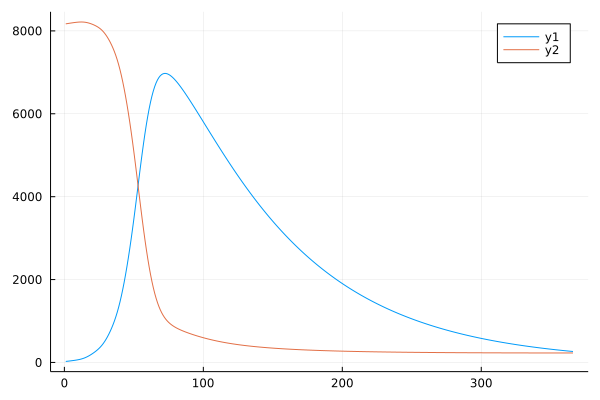

In [77]:
plot(disease_sum)
plot!(pop_sum)

In [12]:
exp,alive,prev,dec,dieout,peak = one_population_analysis(output);

Need to Reduce Timestep
Need to Reduce Timestep
Need to Reduce Timestep


In [14]:
mean(exp)

98.02

In [16]:
mean(alive)

69.76

In [19]:
dieout

10-element Vector{Int64}:
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1

In [10]:
function one_population_analysis(output)
    
    stats = 6
    years_till_endemic = 3
    classes, t_steps, n_ens = size(output) 
    times = output[1].t
    n_g = classes ./ 5

    groups_exposed = Vector{Float64}(undef,n_ens)
    groups_alive = Vector{Float64}(undef,n_ens)
    endemic_prevalence = Vector{Float64}(undef,n_ens)
    population_decrease = Vector{Float64}(undef,n_ens)
    
    die_out_time = Vector{Int64}(undef,n_ens)
    peak_infection_time = Vector{Int64}(undef,n_ens)
    
    for i in 1:n_ens #looping through ensemble_run

        sol = output[i]
        data = reduce(vcat,transpose.(sol.u))

        if any(x->x <0, data)
            println("Need to Reduce Timestep")
            data[data .< 0 ] .= 0
        end
        
        s_d = data[:,1:5:end]
        e_d = data[:,2:5:end]
        i_d = data[:,3:5:end]
        r_d = data[:,4:5:end]
        c_d = data[:,5:5:end]

        disease_total = e_d + i_d + c_d #classes with disease
        disease_alive = e_d + i_d

        disease_free = s_d + r_d #classes without disease
        
        disease_sum = sum(disease_total,dims=2)
        diease_alive_sum =  sum(disease_alive,dims=2)
        disease_free_sum = sum(disease_free,dims=2)
        population_sum = diease_alive_sum + disease_free_sum
        
        #we first want to see dieout time/if the diease was endemic 
        if disease_sum[end] > 0
            #Endemic/still present at end of simulation
            die_out_time[i] = -1
        else #dies out
            dieout_index = findfirst(==(0), disease_sum)[1]
            die_out_time[i] = times[dieout_index]
        end

        #now lets find the maximum time
        max_time_index=findfirst(==(maximum(disease_sum)), disease_sum)[1]
        peak_infection_time[i] = times[max_time_index]

        #Endemic prevalence and groups alive
        if die_out_time[i] == -1 #if endemic
            prevalence = 100*(diease_alive_sum ./ population_sum)
            e_prev = prevalence[365*years_till_endemic:end]
            endemic_prevalence[i] = mean(e_prev)
        else
            endemic_prevalence[i] = 0
        end

        #now looking at the number of groups alive at either dieout time or end if endemic
        exposed_groups = sum(disease_total, dims = 1)
        n_exposed = count(>(0), exposed_groups)
        groups_exposed[i] = 100*n_exposed/n_g
        
        population_decline = 100(1-minimum(population_sum)/population_sum[1])
        population_decrease[i] = population_decline
        
        
        #Now want to look at minimum number of groups alive

        mimum_alive = minimum(sum((disease_alive + disease_free) .> 0, dims = 2))
        groups_alive[i] = 100*mimum_alive/n_g
    end
    
    return groups_exposed, groups_alive, endemic_prevalence, population_decrease, die_out_time, peak_infection_time 

end


one_population_analysis (generic function with 1 method)

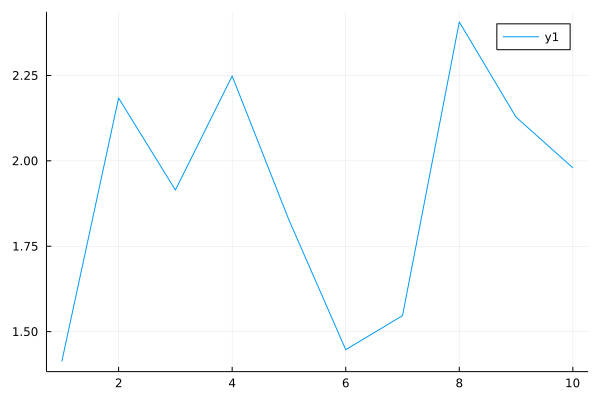

In [120]:
plot(prev)

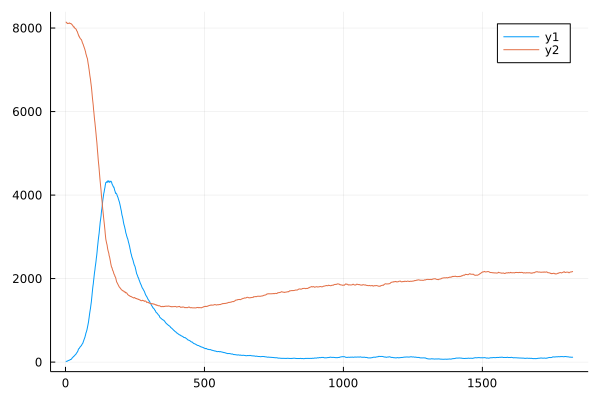

In [125]:
plot(disease_sum)
plot!(disease_free_sum)

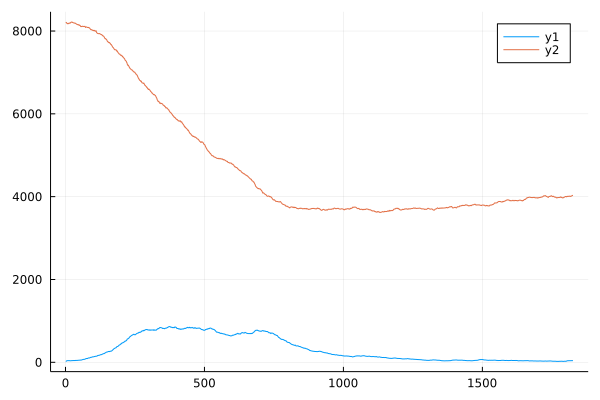

In [374]:
plot(disease_sum)
plot!(disease_free_sum)

In [11]:
yx = [10,2,3,5,7,89]
xx = 1:6

1:6

In [55]:
input_1.Parameters.β.*20

1000×1000 Matrix{Float64}:
 12.241       0.0         0.095097   …   0.0         0.0         0.0
  0.0        11.8571      0.0            0.100393    0.100583    0.103102
  0.099558    0.0        11.9145         0.0         0.0         0.101152
  0.103247    0.0         0.100286       0.10231     0.101677    0.0
  0.103479    0.0         0.0            0.0         0.0         0.101522
  0.0         0.0         0.0        …   0.0         0.0         0.0
  0.0         0.100427    0.0995922      0.100056    0.0         0.0
  0.0         0.0         0.0989958      0.0         0.0975902   0.0
  0.0         0.0         0.098897       0.0         0.0997856   0.0991314
  0.0         0.0996006   0.0            0.0         0.0         0.0
  0.102165    0.0943391   0.0990532  …   0.0         0.0         0.0
  0.0         0.100454    0.0            0.0         0.0         0.0
  0.0         0.0         0.0950433      0.0         0.0         0.0
  ⋮                                  ⋱                 

In [134]:
input_1 = ASF_Inputs.Model_Data(input_path); #creating parameters to run model

Watts Strogatz Small Worlds Network


In [ ]:
s

In [8]:
input_1 = ASF_Inputs.Model_Data(input_path); #creating parameters to run model

N_years = 20
n_ens = 10

rj = RegularJump(ASF_Model.density_rate, regular_c, eqs*nt)

prob = DiscreteProblem(input_1.U0,(0.0,365.0*N_years),input_1.Parameters)

jump_prob = JumpProblem(prob,Direct(),rj)

sol = solve(jump_prob, SimpleTauLeaping(), dt= 1)



data = reduce(vcat,transpose.(sol.u))
    
if any(x->x <0, data)
    println("Need to Reduce Timestep")
    data[data .< 0 ] .= 0
end

s_d = data[:,1:5:end]
e_d = data[:,2:5:end]
i_d = data[:,3:5:end]
r_d = data[:,4:5:end]
c_d = data[:,5:5:end]

disease = e_d + i_d + c_d #classes with disease
disease_free = s_d + r_d #classes without disease

disease_sum = sum(disease,dims=2);
pop_sum = sum(disease_free,dims=2);



Watts Strogatz Small Worlds Network


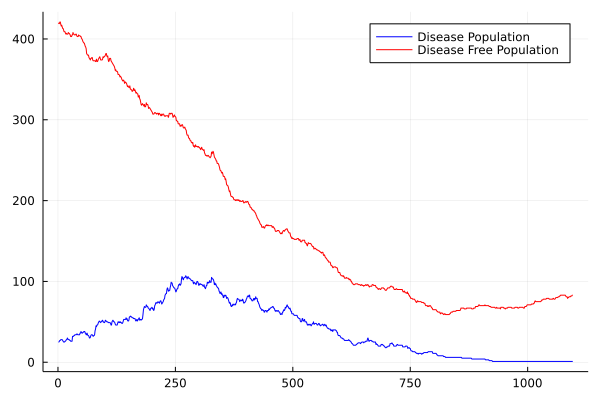

In [12]:
plot(disease_sum, color="blue",label="Disease Population")
plot!(pop_sum, color="red",label="Disease Free Population")
#savefig("small_6_80.png")

In [10]:
n_sims = 100
final_pops = Vector{Int16}(undef, n_sims)


for i in 1:n_sims
    sol = output[i]
    data = reduce(vcat,transpose.(sol.u))
    
    if any(x->x <0, data)
        println("Need to Reduce Timestep")
        data[data .< 0 ] .= 0
    end
    
    s_d = data[:,1:5:end]
    e_d = data[:,2:5:end]
    i_d = data[:,3:5:end]
    r_d = data[:,4:5:end]
    c_d = data[:,5:5:end]
    
    disease = e_d + i_d + c_d #classes with disease
    disease_free = s_d + r_d #classes without disease
    
    disease_sum = sum(disease,dims=2)
    pop_sum = sum(disease+disease_free,dims=2)
    
    N = s_d + e_d + i_d+ r_d + c_d;

    final_pop = sum(N[end,:])
    final_pops[i] = final_pop
end 

LoadError: BoundsError: attempt to access 10-element Vector{ODESolution{Int64, 2, Vector{Vector{Int64}}, Nothing, Nothing, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}, Nothing, DiscreteProblem{Vector{Int64}, Tuple{Float64, Float64}, true, Main.ASF_Inputs.Model_Parameters, DiscreteFunction{true, SciMLBase.var"#158#159", Nothing, Nothing}, Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}}, SimpleTauLeaping, SciMLBase.ConstantInterpolation{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}, Vector{Vector{Int64}}}, Nothing}} at index [11]

## Running Multiple Networks

In [8]:
function sensitivity(n_networks, n_dist, n_runs, path, name)
    
    input_folder = splitpath(path)[end]
    base_path = rsplit(path, input_folder)[1]

    #making save directory
    dir = "$(base_path)Results/$(name)"

    isdir(dir) || mkdir(dir)
    cd(dir)

    #copying inputs
    cp("$(path)", "Inputs",force = true)
    
    for i = 1:n_networks
        println("$(100*i/n_networks) %")
        inputs = ASF_Inputs.Model_Data(path); #creating parameters to run model
        for j = 1:n_dist

            rj = RegularJump(ASF_Model.density_rate,regular_c,eqs*nt)
            prob = DiscreteProblem(inputs.U0,inputs.Time,inputs.Parameters)
            jump_prob = JumpProblem(prob,Direct(),rj) 
            ensemble_prob_m = EnsembleProblem(jump_prob)
            outputs = solve(ensemble_prob_m, SimpleTauLeaping(), trajectories= n_runs,EnsembleThreads(),dt=1);

            summary = ASF_Analysis.quick_analysis(outputs, inputs) #update to new function from module (ASF_Model.quick_analysis(outputs))

            writedlm( "Results_$(i)_$(j).csv",  summary, ',')
            ASF_Model.reparam!(inputs) #re-doing params with
        end
        

    end
    re
end

sensitivity (generic function with 1 method)

In [13]:
function sensitivity2(n_networks, n_dist, n_runs, path)
    sumss = Vector{Float64}(undef, n_networks*n_dist*n_runs)
    println(n_runs)
    println(n_dist)
    println(n_networks)
    for i = 1:n_networks
        println("$(100*i/n_networks) %")
        inputs = ASF_Inputs.Model_Data(path); #creating parameters to run model

        inputs.U0[1:5:end] += (inputs.U0[2:5:end] +inputs.U0[3:5:end])
        inputs.U0[2:5:end] .= 0;
        inputs.U0[3:5:end] .= 0;

        for j = 1:n_dist

            rj = RegularJump(ASF_Model.density_rate,regular_c,eqs*nt)
            prob = DiscreteProblem(inputs.U0,inputs.Time,inputs.Parameters)
            jump_prob = JumpProblem(prob,Direct(),rj) 
            ensemble_prob_m = EnsembleProblem(jump_prob)
            outputs = solve(ensemble_prob_m, SimpleTauLeaping(), trajectories= n_runs,EnsembleThreads(),dt=1);

            #summary = ASF_Analysis.quick_analysis(outputs, inputs) #update to new function from module (ASF_Model.quick_analysis(outputs))

            for k = 1:n_runs
                final_p = sum(outputs[k].u[end])/sum(inputs.U0)
                sumss[n_networks*(i-1)+k] = final_p
            end
            ASF_Model.reparam!(inputs) #re-doing params with
        end
        

    end
    return sumss
end

sensitivity2 (generic function with 1 method)

In [16]:
sq = sensitivity2(10,1,10, input_path)

10
1
10
10.0 %
Watts Strogatz Small Worlds Network
20.0 %
Watts Strogatz Small Worlds Network
30.0 %
Watts Strogatz Small Worlds Network
40.0 %
Watts Strogatz Small Worlds Network
50.0 %
Watts Strogatz Small Worlds Network
60.0 %
Watts Strogatz Small Worlds Network
70.0 %
Watts Strogatz Small Worlds Network
80.0 %
Watts Strogatz Small Worlds Network
90.0 %
Watts Strogatz Small Worlds Network
100.0 %
Watts Strogatz Small Worlds Network


100-element Vector{Float64}:
 1.1666666666666667
 1.1976190476190476
 1.088095238095238
 0.9333333333333333
 1.269047619047619
 0.9642857142857143
 1.0642857142857143
 1.1142857142857143
 1.0333333333333334
 1.1547619047619047
 1.0476190476190477
 0.8523809523809524
 0.9666666666666667
 ⋮
 0.9238095238095239
 1.1714285714285715
 1.1547619047619047
 0.8904761904761904
 0.7452380952380953
 0.9214285714285714
 1.0285714285714285
 1.019047619047619
 0.9428571428571428
 1.1833333333333333
 0.9761904761904762
 0.8904761904761904

In [17]:
mean(sq)

1.0347619047619048

In [90]:
i = 10
k = 1
10*(i-1)+k

91

In [42]:
input_1.U0[1:5:end] += (input_1.U0[2:5:end] +input_1.U0[3:5:end])
input_1.U0[2:5:end] .= 0;
input_1.U0[3:5:end] .= 0;



0

In [84]:
i = 1
j = 5
k = 10

for i = 1:10
    for j =1:5
        for k= 1:10
            println(50*(i-1)+10*(j-1)+k)
        end
    end
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [79]:
5*5*5

125

In [56]:
sum(output[1].u[end])/sum(input_1.U0)

0.9748283752860412

In [9]:
sensitivity(10,10,10,Linear, "ET") # running 

10.0 %
 Barabasi Albert Scale Free Network
Need to Reduce Timestep
20.0 %
 Barabasi Albert Scale Free Network
Need to Reduce Timestep
Need to Reduce Timestep
Need to Reduce Timestep
30.0 %
 Barabasi Albert Scale Free Network
Need to Reduce Timestep
Need to Reduce Timestep
40.0 %
 Barabasi Albert Scale Free Network
Need to Reduce Timestep
Need to Reduce Timestep
50.0 %
 Barabasi Albert Scale Free Network
60.0 %
 Barabasi Albert Scale Free Network
Need to Reduce Timestep
Need to Reduce Timestep
Need to Reduce Timestep
70.0 %
 Barabasi Albert Scale Free Network
Need to Reduce Timestep
Need to Reduce Timestep
Need to Reduce Timestep
Need to Reduce Timestep
Need to Reduce Timestep
80.0 %
 Barabasi Albert Scale Free Network
Need to Reduce Timestep
Need to Reduce Timestep
90.0 %
 Barabasi Albert Scale Free Network
100.0 %
 Barabasi Albert Scale Free Network


## Analysing Output

In [ ]:
density = ASF_Analysis.read_outputs("/home/callum/ASF/Results/Baseline//");
connect_5 = ASF_Analysis.read_outputs("/home/callum/ASF/Results/Connect_5//");


In [ ]:
density_r = ASF_Analysis.three_statistics(density,20, p_out = true);

In [ ]:
connect_5_r = ASF_Analysis.three_statistics(connect_5,20, p_out = true);

In [34]:
using DifferentialEquations, BenchmarkTools

In [35]:
function lorenz(u,p,t)
    dx = 10.0*(u[2]-u[1])
    dy = u[1]*(28.0-u[3]) - u[2]
    dz = u[1]*u[2] - (8/3)*u[3]
    [dx,dy,dz]
   end

lorenz (generic function with 1 method)

In [39]:
u0 = [1.0;0.0;0.0]
tspan = (0.0,100.0)
prob = ODEProblem(lorenz,u0,tspan)
@benchmark solve(prob,Tsit5())

BenchmarkTools.Trial: 836 samples with 1 evaluation.
 Range (min … max):  2.285 ms … 64.586 ms  ┊ GC (min … max):  0.00% … 77.55%
 Time  (median):     4.778 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   5.957 ms ±  6.021 ms  ┊ GC (mean ± σ):  19.54% ± 16.87%

  ▆▃▂▁█▇▄▃▁▁                                                  
  ██████████▆▆▇▇▅▆▅▄▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▅▇▆▅▄▆▅▅▆ ▇
  2.29 ms      Histogram: log(frequency) by time     32.1 ms <

 Memory estimate: 10.81 MiB, allocs estimate: 100152.

In [37]:
u0 = [1.0;0.0;0.0]
tspan = (0.0,100.0)
prob = ODEProblem(lorenz,u0,tspan)
@benchmark solve(prob,Tsit5(),save_everystep=false)

BenchmarkTools.Trial: 1021 samples with 1 evaluation.
 Range (min … max):  2.064 ms … 28.984 ms  ┊ GC (min … max):  0.00% … 83.13%
 Time  (median):     4.140 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   4.876 ms ±  4.557 ms  ┊ GC (mean ± σ):  19.12% ± 17.12%

  ▆▃▂ █▆▅▃▁                                                   
  █████████▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▆▆▇▆▆▆ █
  2.06 ms      Histogram: log(frequency) by time     27.6 ms <

 Memory estimate: 9.47 MiB, allocs estimate: 88645.

In [113]:
function SEIRC_ODE!(du,u,p,t)
    
    ref_density = 3
    
    u[u.<0].=0 
    
    S = u[1:5:end]
    E = u[2:5:end]
    I = u[3:5:end]
    R = u[4:5:end]
    C = u[5:5:end]
  
    N = S + E + I + R + C .+ 0.0001
    Np = S + E + I + R
    
    Pops = p.Populations 
    
    tp = Pops.cum_sum[end]

    beta = copy(p.β)
    
   
    #calculating density of region
    #for i in 1:Pops.pop
    #    nf = Pops.feral[i] #number of feral groups in region
    #    ncs = Pops.cum_sum[i] #cumsum of farm and ferals over all regions
    N_feral = sum(Np) #total feral population in region i
    Density = N_feral/Pops.area[1]
    beta = beta * Density/ref_density
   #end

    column(i) = N .+ N[i]
    populations  = hcat([column(i) for i=1:tp]...)
    populations[diagind(populations)] = N;

    connected_pops = p.β_b * Np

    #procceses 
    Births = p.μ_b .* Np
    Births[(p.μ_c .== 1) .& (Np .> 0)] .= 0 #preventing boar populations growing larger than one!
    Births[(Np .== 0) .& (connected_pops .>2)] .= mean(p.μ_b)*2 #allowing migration births if neighbouring groups have pop
    

    
    du[1:5:end] = Births - ((beta.* S) ./ populations) * (I + p.ω .* C) - p.μ_d .* S + (p.μ_b-p.μ_d)./tanh(1).*S.*tanh.(Np./p.μ_c)  + p.κ .* R #S
    du[2:5:end] = ((beta.* S) ./ populations) * (I + p.ω .* C) - p.ζ .* E - p.μ_d .* E + (p.μ_b-p.μ_d)./tanh(1).*E.*tanh.(Np./p.μ_c) #E
    du[3:5:end] = p.ζ .* E - p.γ .* I -  p.μ_d .* I+ (p.μ_b-p.μ_d)./tanh(1).*I.*tanh.(Np./p.μ_c) #I
    du[4:5:end] = p.γ .* (1 .- p.ρ) .* I - p.μ_d .* R + (p.μ_b-p.μ_d)./tanh(1).*R.*tanh.(Np./p.μ_c) - p.κ .* R  #R
    du[5:5:end] = p.ρ .* p.γ .* I + p.μ_d .* I+ (p.μ_b-p.μ_d)./tanh(1).*I.*tanh.(Np./p.μ_c) - p.λ .* C#C
    nothing
end

SEIRC_ODE! (generic function with 1 method)

In [123]:
input_1 = ASF_Inputs.Model_Data(input_path); #creating parameters to run model
prob = ODEProblem(SEIRC_ODE!,input_1.U0,(0.0,10*365.0),input_1.Parameters);



Watts Strogatz Small Worlds Network


In [129]:
sol=solve(prob, AutoTsit5(Rosenbrock23()),saveat=7);

In [130]:
@benchmark solve(prob, AutoTsit5(Rosenbrock23()),saveat=7)


BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  2.929 s …   3.010 s  ┊ GC (min … max): 5.27% … 5.70%
 Time  (median):     2.969 s              ┊ GC (median):    5.49%
 Time  (mean ± σ):   2.969 s ± 57.406 ms  ┊ GC (mean ± σ):  5.49% ± 0.31%

  █                                                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  2.93 s         Histogram: frequency by time        3.01 s <

 Memory estimate: 7.82 GiB, allocs estimate: 397178.

In [108]:
@benchmark solve(prob, AutoTsit5(Rosenbrock23()),saveat=1)


BenchmarkTools.Trial: 31 samples with 1 evaluation.
 Range (min … max):  100.974 ms … 378.034 ms  ┊ GC (min … max): 9.07% … 3.35%
 Time  (median):     139.255 ms               ┊ GC (median):    6.58%
 Time  (mean ± σ):   161.447 ms ±  63.160 ms  ┊ GC (mean ± σ):  4.81% ± 3.08%

       █▂ ▂                                                      
  ▅▅▅█▁██▁██▁██▁▅█▁▁▅▁▁▁▁▁▅▁▁▁▅▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁▁▁▁▅ ▁
  101 ms           Histogram: frequency by time          378 ms <

 Memory estimate: 276.59 MiB, allocs estimate: 137497.

In [72]:
@benchmark solve(prob, Tsit5(),saveat=1)


BenchmarkTools.Trial: 24 samples with 1 evaluation.
 Range (min … max):  165.093 ms … 405.765 ms  ┊ GC (min … max): 3.57% … 3.42%
 Time  (median):     198.683 ms               ┊ GC (median):    5.98%
 Time  (mean ± σ):   211.110 ms ±  51.758 ms  ┊ GC (mean ± σ):  5.11% ± 1.63%

  █   ▁▄  ▄  ▁▁                                                  
  █▁▁▁██▆▆█▆▁██▁▁▆▁▁▁▁▆▁▁▁▆▁▁▁▁▁▁▁▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆ ▁
  165 ms           Histogram: frequency by time          406 ms <

 Memory estimate: 597.16 MiB, allocs estimate: 78284.

In [103]:
p = [β, β_b,β_d,μ_b,μ_d,μ_c,ζ,γ,ω,ρ,λ,κ, pops]; 



In [101]:
β = input_1.Parameters.β
β_b = input_1.Parameters.β_b
β_d= input_1.Parameters.β_d
μ_b= input_1.Parameters.μ_b
μ_d= input_1.Parameters.μ_d
μ_c= input_1.Parameters.μ_c
ζ= input_1.Parameters.ζ
γ= input_1.Parameters.γ
ω= input_1.Parameters.ω
ρ= input_1.Parameters.ρ
λ= input_1.Parameters.λ
κ= input_1.Parameters.κ
pops= input_1.Parameters.Populations


Main.ASF_Inputs.Network_Data(Int16[100], Int16[0], 1, Int16[100], Int16[0, 100], Int16[1], [3.0], [270.3333333333333])

In [99]:
input_1.Parameters.Pops

LoadError: type Model_Parameters has no field Pops